# Simulate Bernoulli distributed tags for Bernoulli distributed true/false clusters

1. Simulate N clusters. With probability p, each cluster is a "true positive". With 1-p it is a "false positive".
2. Simulate Nt tags (by Nt different taggers) for each cluster. These tags are 0/1 and denote the existence of a tag referring to each cluster by each tagger. Denote: $X_j=1$ if cluster $j$ is a true positive, $X_j=0$ otherwise.
If a cluster if a true positive, tagger i tags the cluster with probability $p_i$.
If a cluster if a false positive, tagger i tags the cluster with probability $q_i$.
3. Perform iterative algorithm to estimate $X_j$, $p_i$, $q_i$.

In [2]:
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt

In [70]:
# parameters
Nt = 3 # number of taggers
N = 10000 #10000 # number of clusters to simulate
p_gt = 0.8 # probability of a cluster to be a true positive

## Simulate Data

In [71]:
# properties of clusters
# draw the number of true clusters - Ntrue - from a binomial distribution.
Ntrue = np.random.binomial(N, p_gt)

In [72]:
# properties of taggers
# draw the values of the pi's from a uniform distribution in [0,1]
p = np.random.uniform(low=0.5, high=1, size=(Nt)) #p[i] is the detection probability of tagger i
q = np.random.uniform(low=0, high=0.25, size=(Nt)) #q[i] is the false detection probability of tagger i

In [73]:
# simulate tags for each of the clusters
clusters = [None]*N
# use the first Ntrue spots in clusters to store the true positive cluster (since our method won't rely on this)
for k in range(N):
    # k
    if k<Ntrue: # the k-th cluster is a true positive cluster
        clusters[k] = np.random.binomial(1, p=p) # draw Bernoulli random variables (binomial n=1) for all tags
    else: # the k-th cluster is a false positive cluster
        clusters[k] = np.random.binomial(1, p=q)
        
clusters = np.array(clusters) # cast into a N x Nt numpy array

In [74]:
# properties of the simulated data and taggers:
print('Number of true clusters: ', Ntrue)
print('p = ', p)
print('q = ', q)

Number of true clusters:  7983
p =  [0.92265254 0.83034147 0.79185647]
q =  [0.05005261 0.1132698  0.13309634]


In [75]:
# sanity check - the ratio of true, false positives each tagger tagged (should be approximately equal to p, q)
ratio_tp_detected = np.mean(clusters[:Ntrue],axis=0)
ratio_fp_detected = np.mean(clusters[Ntrue:],axis=0)
print('ratio of true positive detection: ', ratio_tp_detected)
print('ratio of false positive detection: ', ratio_fp_detected)

ratio of true positive detection:  [0.9214581  0.82074408 0.79280972]
ratio of false positive detection:  [0.04065444 0.11303917 0.12840853]


## Perform estimation

In [76]:
def update_Xj(clusters,p_est,q_est,N):
    l1 = np.zeros(N)
    l0 = np.zeros(N)
    
    eps = 1e-16

    for j in range(N):
        l1[j] = sum(clusters[j,:]*np.log(p_est+eps) + (1-clusters[j,:])*np.log(1-p_est+eps))
        l0[j] = sum(clusters[j,:]*np.log(q_est+eps) + (1-clusters[j,:])*np.log(1-q_est+eps))

    X_est = l1>l0 # 1 if l1>l0, 0 otherwise (this is exactly the argmax)
    
    return X_est

Initialize $\hat{X}_j$

In [77]:
# initialize the estimation of whether a cluster is a true or false positive to be 1 (true) if the number of tags
# is above a threshold (can try different thresholds, here trying mean # of cluster tags)
num_tags = np.sum(clusters, axis=1) # num_tags[j] = number of tags of cluster j
mean_num_tags = np.mean(num_tags)
X_est = num_tags > mean_num_tags

# try all ones initialization
#X_est = np.array([True]*N)

Perform iterations to estimate $\hat{p}_i$, $\hat{q}_i$, $\hat{X}_j$

In [78]:
# initialize variables to collect data
Ntrue_est_list = []
p_list = []
q_list = []

diff_thresh = 1e-10 # could use anything < 1 since X_est is boolean
counter = 0
Nsteps_max= 1000 # if no convergence until reached, exit and display message

# collect data about initialization
Ntrue_est = sum(X_est)
Ntrue_est_list.append(Ntrue_est)

# perform first step of p, q estimation
p_est = np.mean(clusters[X_est,:], axis = 0)
q_est = np.mean(clusters[~X_est,:], axis = 0)
# collect data
p_list.append(p_est)
q_list.append(q_est)

X_est_prev = X_est
X_est = update_Xj(clusters,p,q,N)

while sum(X_est != X_est_prev) > diff_thresh:
    # update p, q estimation
    p_est = np.mean(clusters[X_est,:], axis = 0)
    q_est = np.mean(clusters[~X_est,:], axis = 0)
    
    # collect data
    p_list.append(p_est)
    q_list.append(q_est)

    X_est_prev = X_est
    X_est = update_Xj(clusters,p_est,q_est,N)

    counter += 1
    if counter==Nsteps_max:
        print('Exited without converging after ' + str(Nsteps_max) + ' steps.')
        break
        
    print(counter, sum(X_est != X_est_prev))

print('Converged after ', counter, ' steps.')

1 0
Converged after  1  steps.


# Evaluate results

View estimations of $p_i$ and $q_i$ compared to the true values

In [79]:
p_est

array([0.94047143, 0.86349714, 0.83606339])

In [80]:
p

array([0.92265254, 0.83034147, 0.79185647])

In [81]:
q_est

array([0.1509434 , 0.11882778, 0.12444801])

In [82]:
q

array([0.05005261, 0.1132698 , 0.13309634])

The lists of q, p estimation values in steps of the algorithm until convergence:

In [83]:
q_list

[array([0.50673854, 0.38005391, 0.34308818]),
 array([0.1509434 , 0.11882778, 0.12444801])]

In [84]:
p_list

[array([1., 1., 1.]), array([0.94047143, 0.86349714, 0.83606339])]

What percent of true / false custers are correctly classified?

In [85]:
ratio_tp_detected_est = np.mean(X_est[:Ntrue])
ratio_tp_detected_est

0.9356131780032569

In [86]:
ratio_fp_correctly_classified = np.mean(~X_est[Ntrue:])
ratio_fp_correctly_classified

0.9801685671789787

In [87]:
rat_correct_est = np.mean(np.concatenate((X_est[:Ntrue],~X_est[Ntrue:])))
rat_correct_est

0.9446

Compare to naive estimate of $X_j$ by thresholding: decide cluster is true if # of tags in it > threshold.

For threshold=$N_t/2$ this is majority vote

In [88]:
thresh_list = np.arange(0,3)
rat_tp_correct = np.zeros(len(thresh_list))
rat_fp_correct = np.zeros(len(thresh_list))
rat_correct = np.zeros(len(thresh_list))
for i, thresh in enumerate(thresh_list):
    X_est_thresh = np.sum(clusters, axis=1)>thresh
    rat_tp_correct[i] = np.mean(X_est_thresh[:Ntrue])
    rat_fp_correct[i] = np.mean(~X_est_thresh[Ntrue:])
    rat_correct[i] = np.mean(np.concatenate((X_est_thresh[:Ntrue],~X_est_thresh[Ntrue:])))

Text(0, 0.5, '<correctly classified clusters>')

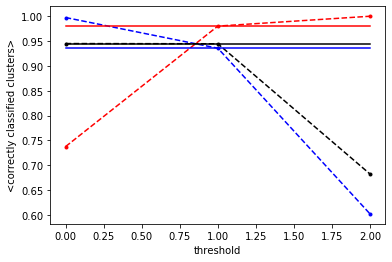

In [89]:
plt.plot(thresh_list,rat_tp_correct,'.--b')
plt.plot(thresh_list,rat_fp_correct,'.--r')
plt.plot(thresh_list,rat_correct,'.--k')
plt.plot(thresh_list,np.ones(len(thresh_list))*ratio_tp_detected_est,'b')
plt.plot(thresh_list,np.ones(len(thresh_list))*ratio_fp_correctly_classified,'r')
plt.plot(thresh_list,np.ones(len(thresh_list))*rat_correct_est,'k')
plt.xlabel('threshold')
plt.ylabel('<correctly classified clusters>')

Calculte the MSE for p, q estimation

In [90]:
np.mean((p-p_est)**2)

0.0011236878155561209

In [91]:
np.mean((q-q_est)**2)

0.003428211793215932

In [20]:
np.unique(X_est)

array([False,  True])